# Dự đoán giá nhà ở California
- Dữ liệu chúa thông tin từ cuộc điều tra dân số California năm 1990.
- Dữ liệu liên quan đến những ngôi nhà được tìm thấy ở một số quận nhất định của California và một số số liệu thống kê tóm tắt về chúng dựa trên dữ liệu điều tra dân số năm 1990.

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from scipy import stats

from typing import List
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

## Phân tích khai phá dữ liệu - EDA

In [3]:
df = pd.read_csv('./Data/housing.csv')

In [4]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
df.shape

(20640, 10)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
target_col = 'median_house_value'
num_cols = [col for col in df.select_dtypes(include=np.number).columns.drop(target_col)]
cat_cols = [col for col in df.select_dtypes(exclude=np.number).columns]

num_cols
cat_cols

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

['ocean_proximity']

|Thứ tự|Tên thuộc tính|Mô tả|Đặc trưng|
|-|-|-|-|
|1|Longitude|Kinh độ - Thước đo khoảng cách của một ngôi nhà về hướng Tây; giá trị cao hơn là xa hơn về phía Tây|Numerical|
|2|Latitude|Vĩ độ - Thước đo khoảng cách của một ngôi nhà về phía Bắc; giá trị cao hơn ở xa hơn về phía Bắc|Numerical|
|3|Housing median age|Tuổi trung bình của một ngôi nhà trong 1 lô đất; số thấp hơn là tòa nhà mới hơn|Numerical|
|4|Total rooms|Tổng số phòng trong một lô đất|Numerical|
|5|Total bedrooms|Tổng số phòng ngủ trong một lô đất|Numerical|
|6|Population|Tổng số người cư trú trong một lô đất|Numerical|
|7|Households|Tổng số hộ gia đình, một nhóm người cư trú trong một lô đất|Numerical|
|8|Median income|Thu nhập trung bình của các hộ gia đình trong một lô đất (chục nghìn $)|Numerical|
|9|Median house value|Giá trị nhà trung bình của các hộ gia đình trong một lô đất (chục nghìn $)|Target|
|10|Ocean proximity|Vị trí của ngôi nhà so với đại dương/biển|Categorical|

In [8]:
df.isna().sum()*100 / df.shape[0]

longitude             0.000000
latitude              0.000000
housing_median_age    0.000000
total_rooms           0.000000
total_bedrooms        1.002907
population            0.000000
households            0.000000
median_income         0.000000
median_house_value    0.000000
ocean_proximity       0.000000
dtype: float64

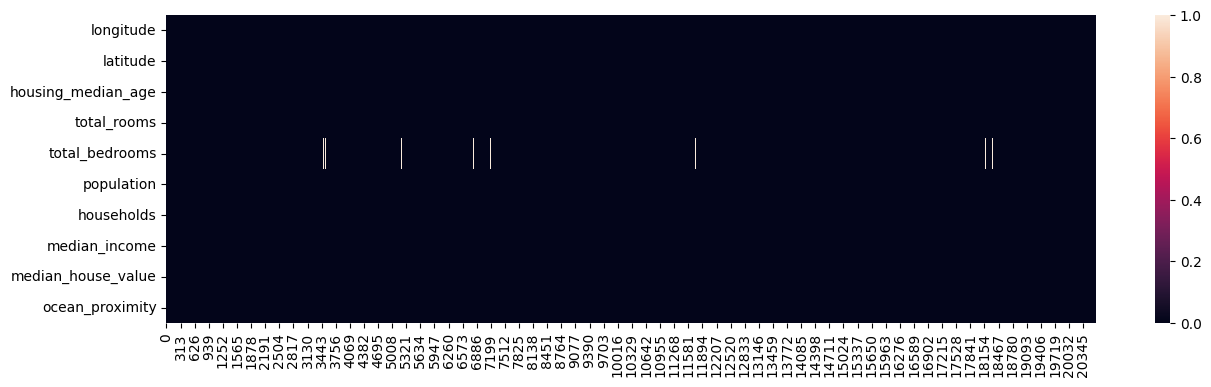

In [9]:
#Hiển thị giá trị thiếu dựa trên vị trí
fig, ax = plt.subplots(figsize=(15,4))
sns.heatmap(df.isna().transpose(), ax=ax)
plt.show();

In [8]:
df.duplicated().sum()

0

**Đánh giá**
- `total_bedrooms` có 1% dữ liệu bị thiếu, không đáng kể
    - Xử lý ngay: có thể điền bằng giá trị trung bình của `total_bedrooms`
    - Xử lý triệt để: hồi quy dựa vào các đặt trưng quyết định đến số lượng phòng - `total_rooms` `population` `households`
- Không có dữ liệu bị trùng lặp

### Target: Median house value

In [10]:
def plot_dist(df, xlable='price'):
    df = df[xlable]
    _, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
    sns.histplot(df, bins=40, ax=ax1)
    ax1.set(title='Histogram', ylabel='Frequency', xlabel=xlable)
    
    #Q-Q plot
    stats.probplot(df, plot=ax2)
    ax2.set_title('Q-Q plot')
    plt.show();

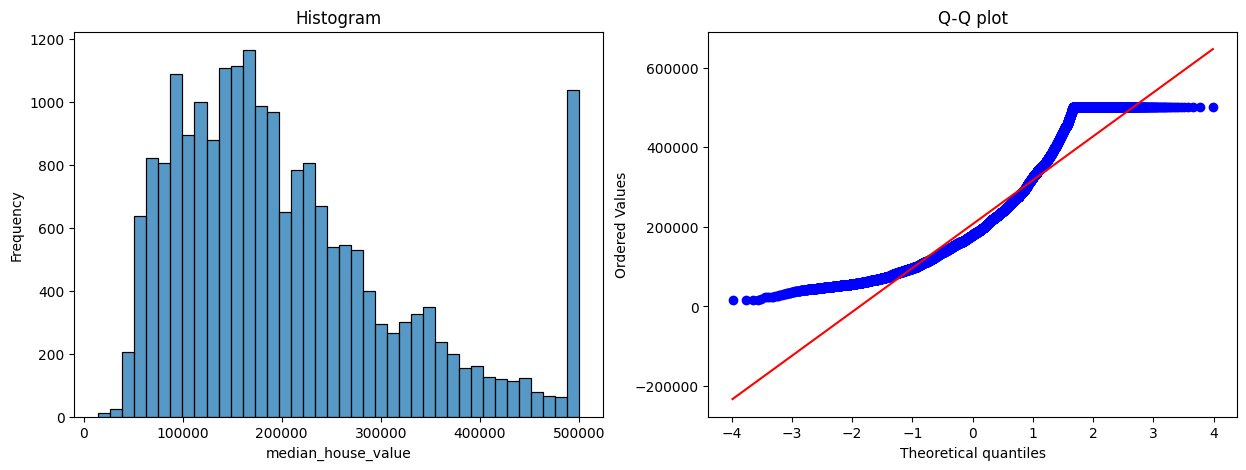

In [11]:
plot_dist(df, xlable='median_house_value')

In [12]:
df.query('median_house_value > 500000').shape[0]

965

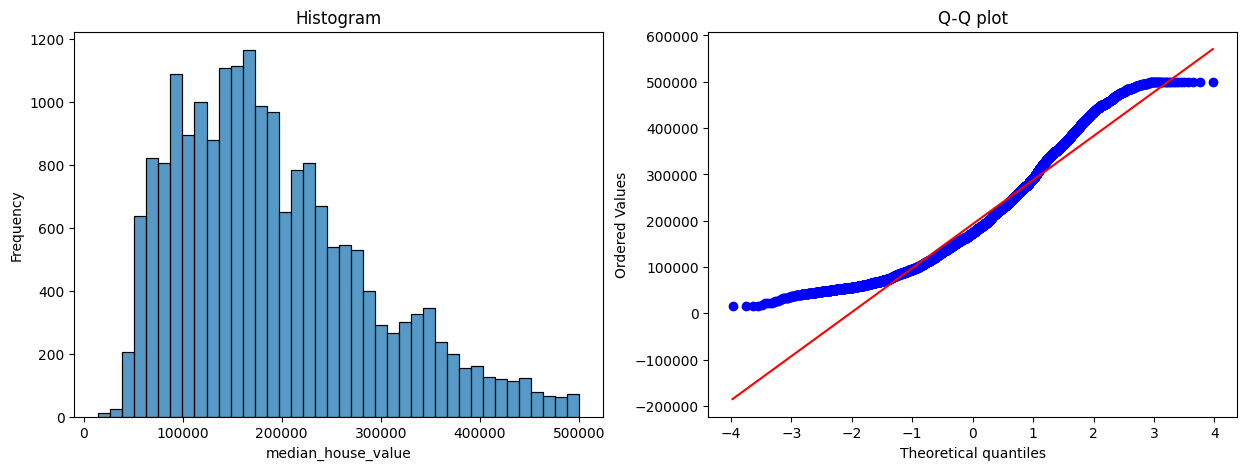

In [13]:
plot_dist(df.query('median_house_value <= 500000'), 'median_house_value')

**Đánh giá:** Giá nhà giao động chủ yếu trong khoảng 60 000$ - 230 000$, có ít nhà có giá trị cao, tuy nhiên có 1 số lượng lớn nhà có mức giá 500 001$ (cũng là giá trị lớn nhất)

### Đăc trưng Categorical

In [14]:

def plot_count(df, col_name, sort=False, rotation=0, figsize=(12,4)):
    _, ax = plt.subplots(figsize=figsize)
    order = df[col_name].value_counts().index if sort else None
    sns.countplot(data=df, x=col_name, ax=ax, order = order)
    plt.show();

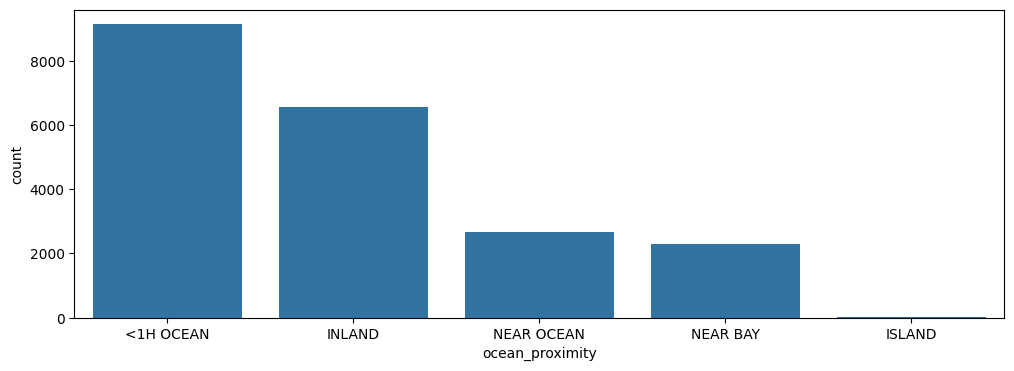

In [15]:
plot_count(df, 'ocean_proximity', sort=True)

In [16]:
summary_df = df.groupby('ocean_proximity')['median_house_value'].agg(['mean','median','std']).sort_values('mean')
summary_df

,mean,median,std
ocean_proximity,,,
INLAND,124805.392001,108500.0,70007.908494
<1H OCEAN,240084.285464,214850.0,106124.292213
NEAR OCEAN,249433.977427,229450.0,122477.145927
NEAR BAY,259212.311790,233800.0,122818.537064
ISLAND,380440.000000,414700.0,80559.561816


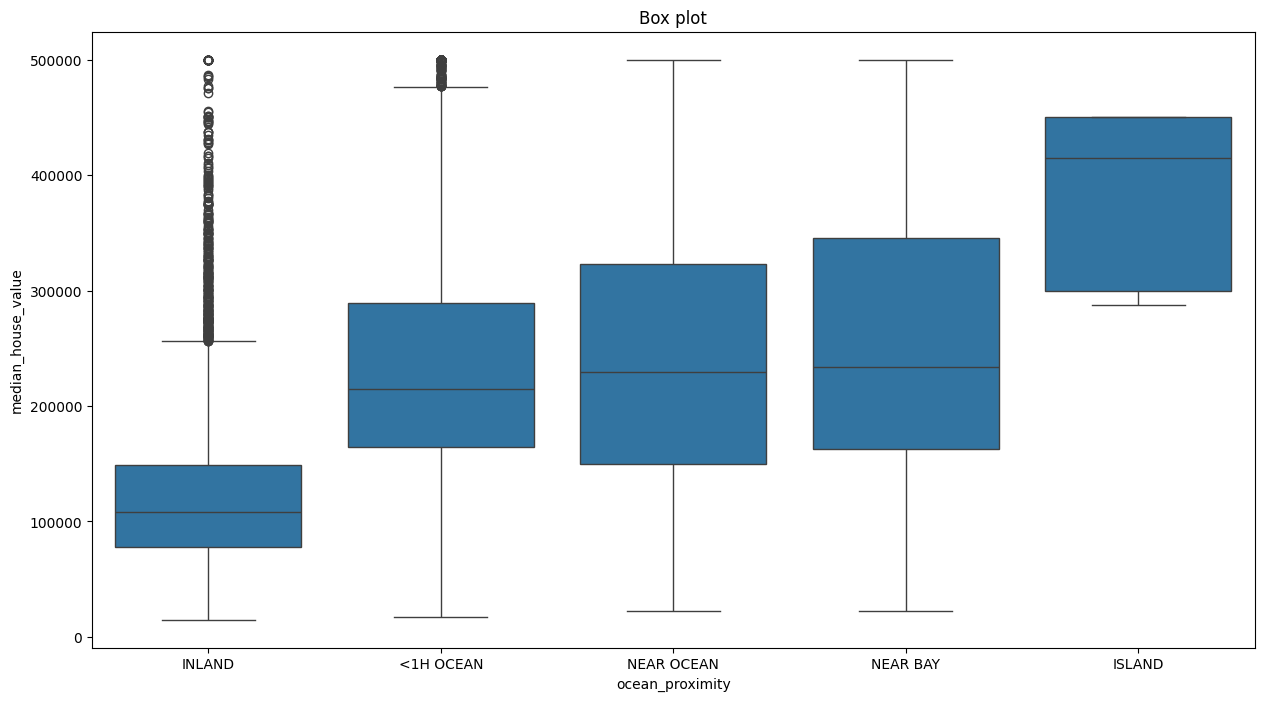

In [17]:
_, ax = plt.subplots(figsize=(15,8))
sns.boxplot(data=df,x='ocean_proximity',y='median_house_value', order=summary_df.index.to_list(), ax=ax)
ax.set(title='Box plot')
plt.show();

### Đặc trưng Numerical

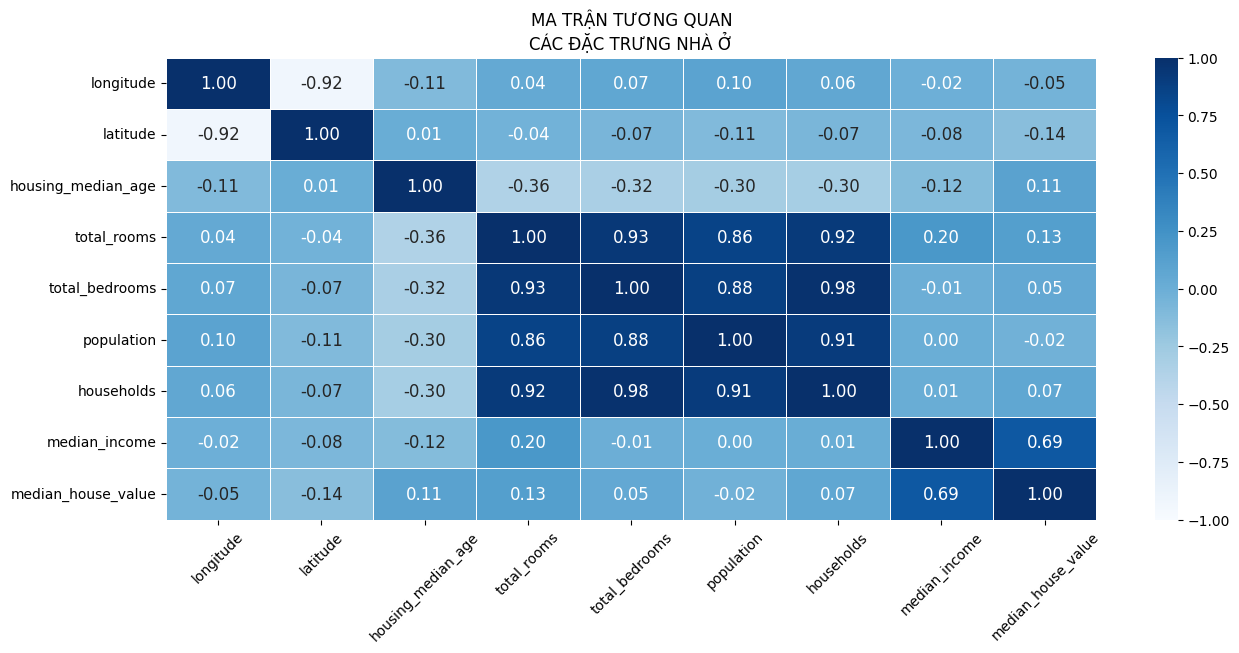

In [18]:
_, ax = plt.subplots(figsize=(15, 6))
#plt.figure(figsize=(15,5))
sns.heatmap(df.corr(numeric_only=True),
            annot_kws={"fontsize":12}, fmt=".2f",
            annot=True,
            cmap='Blues',vmin=-1, vmax=1,
            linecolor='white', linewidths=0.5,
            ax=ax)
ax.set_title('MA TRẬN TƯƠNG QUAN\nCÁC ĐẶC TRƯNG NHÀ Ở')
plt.xticks(rotation=45);

In [19]:
temp = df.copy()

temp['rooms_per_house'] = temp['total_rooms'] / temp['households']
temp['bedrooms_ratio'] = temp['total_bedrooms'] / temp['total_rooms']
temp['people_per_house'] = temp['population'] / temp['households']
corr_matrix = temp.corr(numeric_only=True)
corr_matrix['median_house_value'].sort_values(ascending=False, key=abs)

median_house_value    1.000000
median_income         0.688075
bedrooms_ratio       -0.255880
rooms_per_house       0.151948
latitude             -0.144160
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
longitude            -0.045967
population           -0.024650
people_per_house     -0.023737
Name: median_house_value, dtype: float64

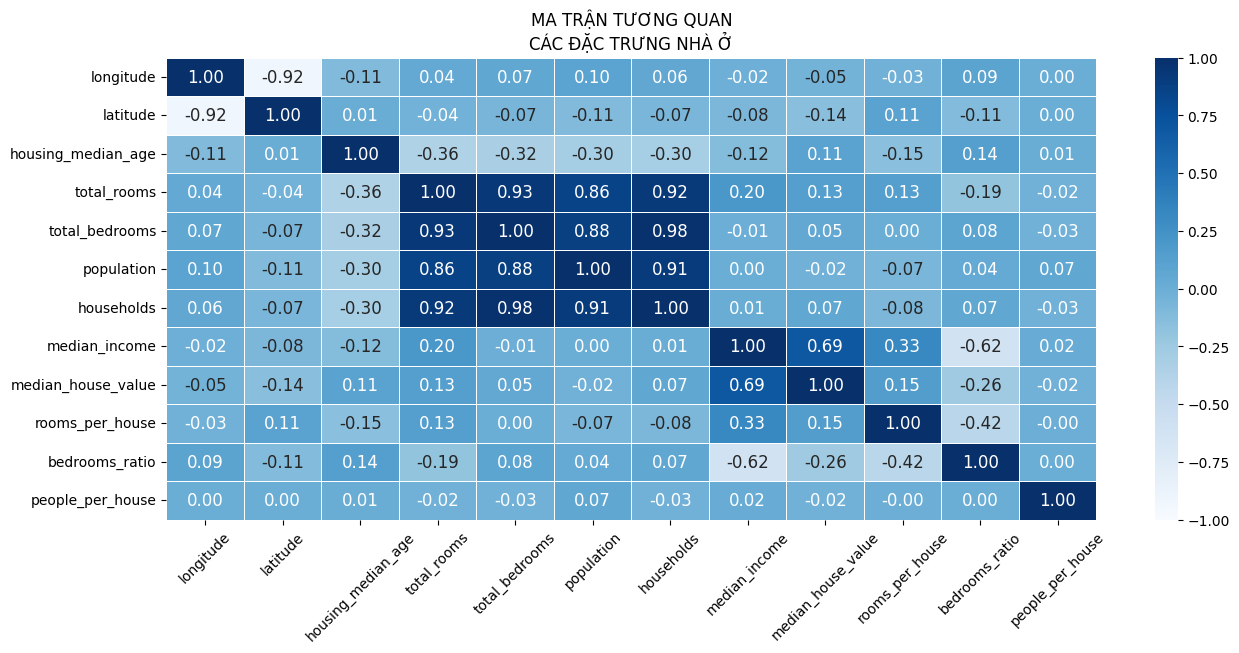

In [20]:
_, ax = plt.subplots(figsize=(15, 6))
#plt.figure(figsize=(15,5))
sns.heatmap(temp.corr(numeric_only=True),
            annot_kws={"fontsize":12}, fmt=".2f",
            annot=True,
            cmap='Blues',vmin=-1, vmax=1,
            linecolor='white', linewidths=0.5,
            ax=ax)
ax.set_title('MA TRẬN TƯƠNG QUAN\nCÁC ĐẶC TRƯNG NHÀ Ở')
plt.xticks(rotation=45);

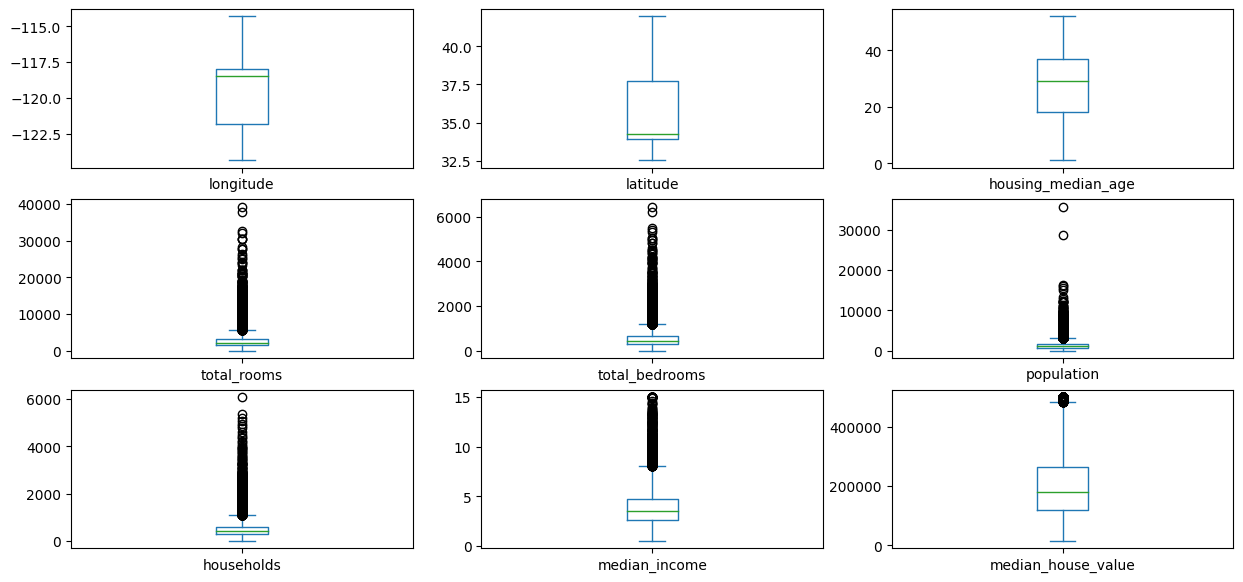

In [21]:
#outline detection
df.plot(kind='box', subplots=True, layout=(3,3), figsize=(15,7))
plt.show();

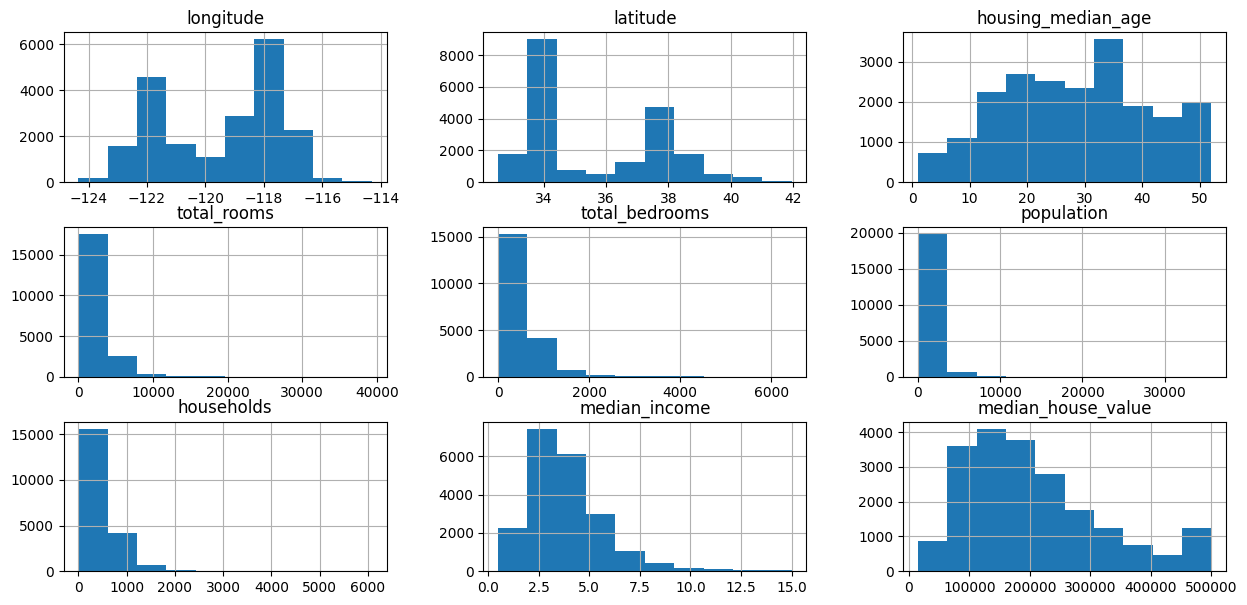

In [22]:
df.hist(figsize=(15,7))
plt.show();

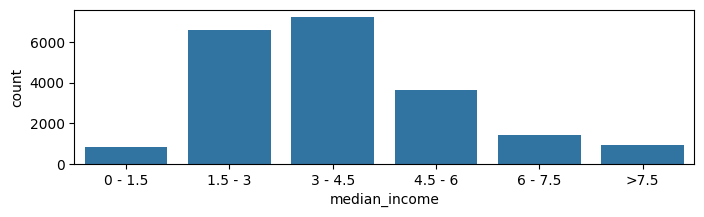

In [23]:
income_bins = pd.cut(df['median_income'],
                     bins=[0, 1.5, 3, 4.5, 6, 7.5, np.inf],
                     labels=['0 - 1.5', '1.5 - 3', '3 - 4.5', '4.5 - 6', '6 - 7.5', '>7.5'])
plt.figure(figsize=(8,2))
sns.countplot(x= income_bins)
plt.show();

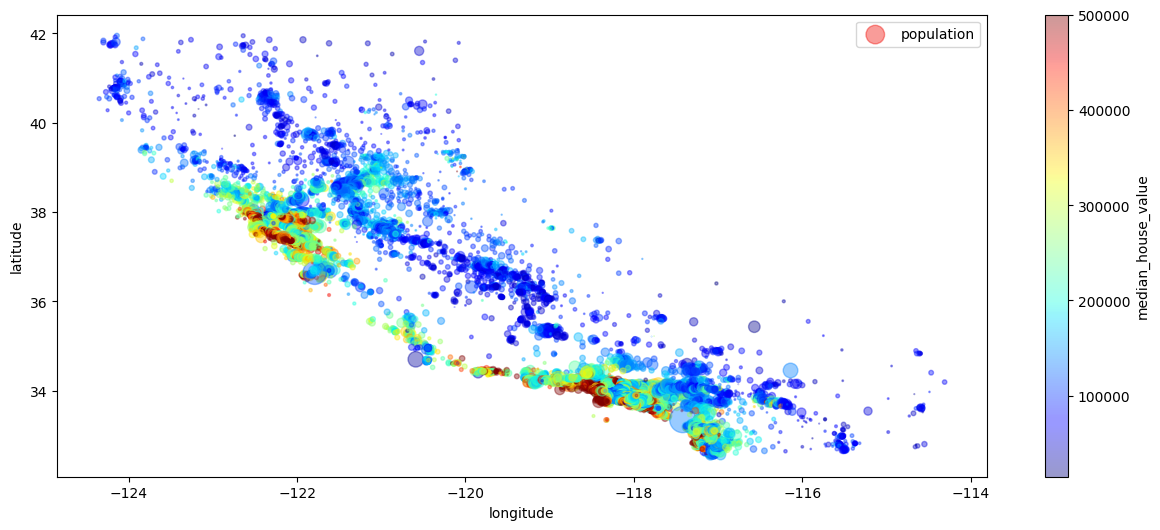

In [24]:
df.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
        s=df['population']/100, label='population', figsize=(15,6),
        c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()
plt.show();

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel

class Cluster(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(n_clusters=self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    def get_feature_names_out(self, name=None):
        return [f'{i}' for i in range(self.n_clusters)]

In [26]:
cluster_simil = Cluster(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(df[["latitude", "longitude"]], 
                                           sample_weight=df["median_house_value"] )
similarities[:3].round(2)

array([[0.  , 0.23, 0.  , 0.99, 0.  , 0.  , 0.  , 0.  , 0.14, 0.63],
       [0.  , 0.23, 0.  , 0.99, 0.  , 0.  , 0.  , 0.  , 0.14, 0.65],
       [0.  , 0.22, 0.  , 0.99, 0.  , 0.  , 0.  , 0.  , 0.13, 0.65]])

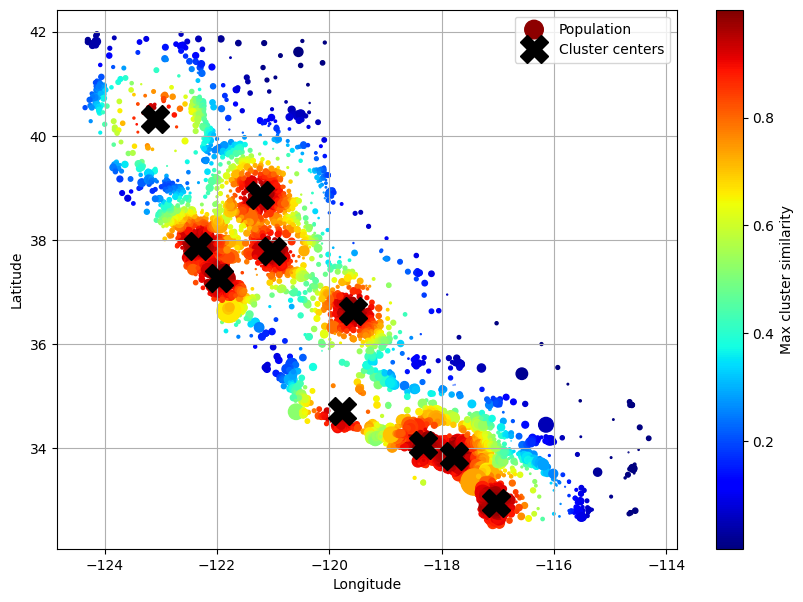

In [27]:
housing_renamed = df.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (USD)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")

plt.show();

**Đánh giá:**
- Phân phối đuôi dài (có nhiều giá trị cách xa giá trị trung bình) `total_rooms` `total_bedrooms` `population` `households`
- Khi chuẩn hóa, nhiều giá trị sẽ bị nén vào 1 phạm vi ảnh hưởng đến mô hình ML
- Phương pháp xử lý:
    - Xử lý phần 'đuôi' bằng cách chia thành các nhóm, thay thế giá trị của các đặc trưng bằng nhãn của nhóm nó thuộc về
    - Chuyển về phân phối chuẩn bằng hàm log
- `housing_median_age` `median_income` có thể chuyển thành categorical
- `total_rooms` `total_bedrooms` `population` `household` có mối liên hệ với nhau
- `longgitude` `latitude` có mối liên hệ với nhau
- `median_income` có tương quan nhất với `median_house_values`
- Xử lý ngoại lệ: Xóa giá trị vượt quá **Q3 + 1.5*IQR**

## Tiền xử lý dữ liệu

In [28]:
features = num_cols + cat_cols
X = df[features]
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True, test_size=0.2)

In [29]:
X_train

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,NEAR OCEAN
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,NEAR OCEAN
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,NEAR OCEAN
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,NEAR OCEAN
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,INLAND
...,...,...,...,...,...,...,...,...,...
11284,-117.96,33.78,35.0,1330.0,201.0,658.0,217.0,6.3700,<1H OCEAN
11964,-117.43,34.02,33.0,3084.0,570.0,1753.0,449.0,3.0500,INLAND
5390,-118.38,34.03,36.0,2101.0,569.0,1756.0,527.0,2.9344,<1H OCEAN
860,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,<1H OCEAN


array([<AxesSubplot:title={'center':'total_rooms'}>], dtype=object)

<AxesSubplot:>

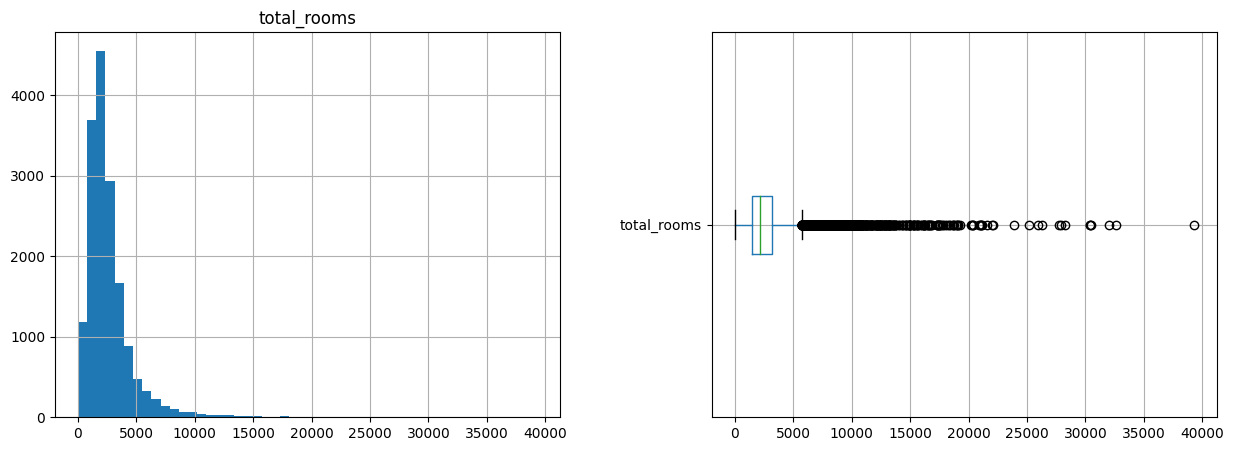

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
X_train[['total_rooms']].hist(bins=50, ax=ax[0])
X_train[['total_rooms']].boxplot(ax=ax[1], vert=False)

In [31]:
q1 = X_train[num_cols].quantile(q=0.25)
q3 = X_train[num_cols].quantile(q=0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr

In [32]:
for col in num_cols:
    lower_bound_value = lower_bound[col]
    upper_bound_value = upper_bound[col]
    
    X_train.loc[X[col] > upper_bound_value, col] = upper_bound_value
    X_train.loc[X[col] < lower_bound_value, col] = lower_bound_value
    
    X_test.loc[X[col] > upper_bound_value, col] = upper_bound_value
    X_test.loc[X[col] < lower_bound_value, col] = lower_bound_value

array([<AxesSubplot:title={'center':'total_rooms'}>], dtype=object)

<AxesSubplot:>

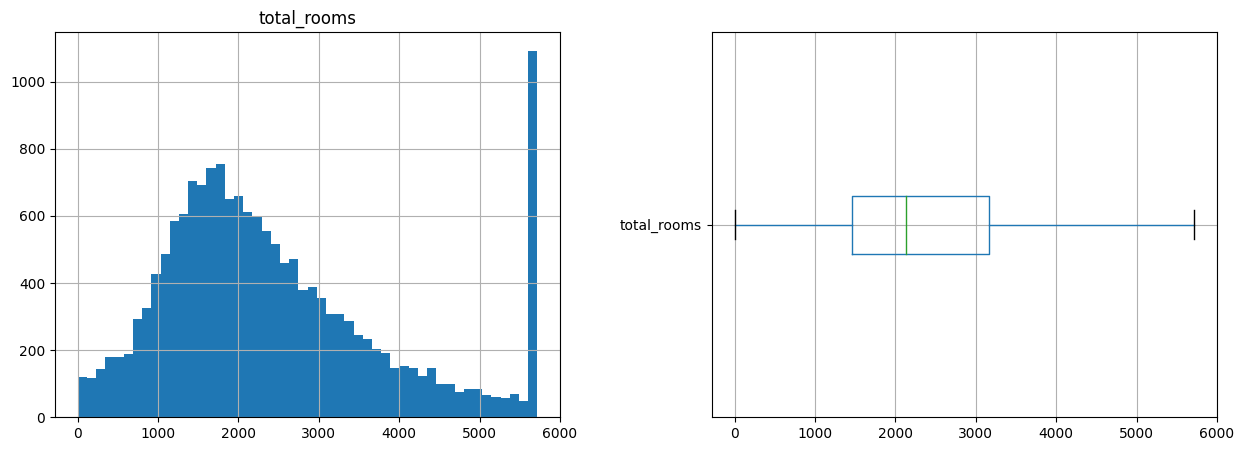

In [59]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
X_train[['total_rooms']].hist(bins=50, ax=ax[0])
X_train[['total_rooms']].boxplot(ax=ax[1], vert=False)

In [33]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FunctionTransformer, Pipeline

def column_ratio(X):
    return X[:,[0]] / X[:,[1]]

def ratio_name(function, name):
    return ['ratio']

ratio_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('function', FunctionTransformer(column_ratio, feature_names_out=ratio_name)),
    ('scaler', StandardScaler())
])

In [34]:
log_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('function', FunctionTransformer(np.log, feature_names_out='one-to-one')),
    ('scaler', StandardScaler())
])

In [35]:
default_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [36]:
from sklearn.preprocessing import OneHotEncoder


cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [37]:
city_cluster = Cluster(n_clusters=8, gamma=1, random_state=42)

|City|Longitude|Latitude|
|-|-|-|
|Los Angeles|-118.25|38,5|
|San Diego|-117.17|32.71|
|San Jose|-121.27|37.3|
|San Francisco|-122.42|37.77|
|Long Beach|-118.17|33.8|
|Fresno|-119.8|36.77|
|Scramento|-121.5|38.5|
|Oakland|-122.27|37.8|
|Santa Ana|-117.88|33.73|

In [38]:
from numpy import sqrt

def distance_LosAngeles_city(X):
    return sqrt(((X[:,[0]]-(-118.25))**2) + ((X[:,[1]]-38.5)**2))
def distance_SanDiego_city(X):
    return sqrt(((X[:,[0]]-(-117.17))**2) + ((X[:,[1]]-32.71)**2))
def distance_SanFrancisco_city(X):
    return sqrt(((X[:,[0]]-(-122.42))**2) + ((X[:,[1]]-37.77)**2))
def distance_LongBeach_city(X):
    return sqrt(((X[:,[0]]-(-118.17))**2) + ((X[:,[1]]-33.8)**2))
def distance_Fresno_city(X):
    return sqrt(((X[:,[0]]-(-119.8))**2) + ((X[:,[1]]-36.77)**2))
def distance_Scramento_city(X):
    return sqrt(((X[:,[0]]-(-121.5))**2) + ((X[:,[1]]-38.5)**2))
def distance_Oakland_city(X):
    return sqrt(((X[:,[0]]-(-122.27))**2) + ((X[:,[1]]-37.8)**2))
def distance_SantaAna_city(X):
    return sqrt(((X[:,[0]]-(-117.88))**2) + ((X[:,[1]]-33.73)**2))
    
def city_name(function, name):
    return ['city']
    
LosAngeles_city_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('function', FunctionTransformer(distance_LosAngeles_city, feature_names_out=city_name)),
    ('scaler', StandardScaler())
])

SanDiego_city_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('function', FunctionTransformer(distance_SanDiego_city, feature_names_out=city_name)),
    ('scaler', StandardScaler())
])

SanFrancisco_city_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('function', FunctionTransformer(distance_SanFrancisco_city, feature_names_out=city_name)),
    ('scaler', StandardScaler())
])

LongBeach_city_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('function', FunctionTransformer(distance_LongBeach_city, feature_names_out=city_name)),
    ('scaler', StandardScaler())
])

Fresno_city_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('function', FunctionTransformer(distance_Fresno_city, feature_names_out=city_name)),
    ('scaler', StandardScaler())
])

Scramento_city_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('function', FunctionTransformer(distance_Scramento_city, feature_names_out=city_name)),
    ('scaler', StandardScaler())
])

Oakland_city_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('function', FunctionTransformer(distance_Oakland_city, feature_names_out=city_name)),
    ('scaler', StandardScaler())
])

SantaAna_city_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('function', FunctionTransformer(distance_SantaAna_city, feature_names_out=city_name)),
    ('scaler', StandardScaler())
])

In [39]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('bedrooms', ratio_pipeline, ['total_bedrooms','total_rooms']),
    ('rooms_per_house', ratio_pipeline, ['total_rooms','households']),
    ('people_per_house', ratio_pipeline, ['population', 'households']),
    ('log', log_pipeline, ['total_bedrooms','total_rooms','population','households','median_income']),
    ('cat', cat_pipeline, ['ocean_proximity']),
    ('default', default_pipeline, ['housing_median_age']),
    ('LosAngeles', LosAngeles_city_pipeline, ['latitude', 'longitude']),
    ('SanDiego', SanDiego_city_pipeline, ['latitude', 'longitude']),
    ('SanFrancisco', SanFrancisco_city_pipeline, ['latitude', 'longitude']),
    ('LongBeach', LongBeach_city_pipeline, ['latitude', 'longitude']),
    ('Fresno', Fresno_city_pipeline, ['latitude', 'longitude']),
    ('Oakland', Oakland_city_pipeline, ['latitude', 'longitude']),
    ('SantaAna', SantaAna_city_pipeline, ['latitude', 'longitude']),
    ('Scramento', Scramento_city_pipeline, ['latitude', 'longitude'])
])



In [40]:
preprocessor.fit(X_train)

temp1 = preprocessor.transform(X_train)
temp2 = preprocessor.transform(X_test)

X_train_prepared = pd.DataFrame(temp1, columns=preprocessor.get_feature_names_out(),index = X_train.index)
X_train_prepared

X_test_prepared = pd.DataFrame(temp2, columns=preprocessor.get_feature_names_out(),index = X_test.index)
X_test_prepared

ColumnTransformer(transformers=[('bedrooms',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('function',
                                                  FunctionTransformer(feature_names_out=<function ratio_name at 0x0000017C45092B80>,
                                                                      func=<function column_ratio at 0x0000017C593299D0>)),
                                                 ('scaler', StandardScaler())]),
                                 ['total_bedrooms', 'total_rooms']),
                                ('rooms_per_house',
                                 Pipeline(steps=[('imp...
                                                                      func=<function distance_SantaAna_city at 0x0000017C450A2C10>)),
                                                 ('scaler', StandardScaler())]),
                                 ['latitude', 'longitude']),
                                ('Scramento',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('function',
                                                  FunctionTransformer(feature_names_out=<function city_name at 0x0000017C450A2CA0>,
                                                                      func=<function distance_Scramento_city at 0x0000017C450A2700>)),
                                                 ('scaler', StandardScaler())]),
                                 ['latitude', 'longitude'])])

,bedrooms__ratio,rooms_per_house__ratio,people_per_house__ratio,log__total_bedrooms,log__total_rooms,log__population,log__households,log__median_income,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,...,cat__ocean_proximity_NEAR OCEAN,default__housing_median_age,LosAngeles__city,SanDiego__city,SanFrancisco__city,LongBeach__city,Fresno__city,Oakland__city,SantaAna__city,Scramento__city
14196,-0.217364,-0.165314,0.117336,0.590759,0.619588,1.049242,0.677797,-0.127692,0.0,0.0,...,1.0,0.348490,-1.349292,-1.350074,-1.350101,-1.350058,-1.349837,-1.350072,-1.350021,-1.349833
8267,0.356482,-0.399120,-0.220783,0.919268,0.730826,0.249823,0.955892,0.215554,0.0,0.0,...,1.0,1.618118,-0.809927,-0.811224,-0.811269,-0.811198,-0.810828,-0.811220,-0.811137,-0.810822
17445,-0.683379,0.104615,-0.050294,-0.332594,-0.086285,-0.266965,-0.209594,0.404702,0.0,0.0,...,1.0,-1.952710,-0.013685,-0.020651,-0.020942,-0.020518,-0.018541,-0.020678,-0.020187,-0.018524
14265,0.813146,-0.601394,0.169696,-0.183367,-0.494581,0.358593,-0.130537,-1.261680,0.0,0.0,...,1.0,0.586545,-1.334151,-1.335318,-1.335361,-1.335295,-1.334964,-1.335317,-1.335240,-1.334959
2271,-0.568091,0.372142,-0.123537,0.048973,0.235457,-0.332428,-0.032729,0.061862,0.0,1.0,...,0.0,1.142008,0.330496,0.333751,0.333868,0.333686,0.332758,0.333745,0.333532,0.332744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,-1.100602,0.312247,0.003190,-1.053571,-0.588110,-0.737791,-0.837966,1.340090,1.0,0.0,...,0.0,0.507194,-0.857459,-0.857944,-0.857958,-0.857934,-0.857795,-0.857940,-0.857911,-0.857792
11964,-0.498706,0.630040,0.154097,0.452999,0.600472,0.661436,0.207073,-0.273295,0.0,1.0,...,0.0,0.348490,-0.931336,-0.928881,-0.928793,-0.928931,-0.929632,-0.928885,-0.929047,-0.929642
5390,1.037395,-0.608312,0.055077,0.450461,0.058060,0.663878,0.437284,-0.357942,1.0,0.0,...,0.0,0.586545,-0.691914,-0.693116,-0.693156,-0.693091,-0.692748,-0.693111,-0.693035,-0.692742
860,-0.817219,0.426684,0.028567,0.519892,0.809257,0.680853,0.522006,1.103993,1.0,0.0,...,0.0,-1.079841,1.063376,1.061237,1.061171,1.061282,1.061896,1.061252,1.061383,1.061909


,bedrooms__ratio,rooms_per_house__ratio,people_per_house__ratio,log__total_bedrooms,log__total_rooms,log__population,log__households,log__median_income,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,...,cat__ocean_proximity_NEAR OCEAN,default__housing_median_age,LosAngeles__city,SanDiego__city,SanFrancisco__city,LongBeach__city,Fresno__city,Oakland__city,SantaAna__city,Scramento__city
20046,1.386454,-0.520015,0.149460,0.068955,-0.413417,0.332167,-0.114434,-1.578172,0.0,1.0,...,0.0,-0.286324,-0.041417,-0.037701,-0.037572,-0.037777,-0.038837,-0.037711,-0.037952,-0.038854
3024,-1.147755,-0.155978,-0.057809,0.068955,0.534336,0.499444,0.584887,-0.681667,0.0,1.0,...,0.0,0.110435,-0.152914,-0.154258,-0.154300,-0.154230,-0.153845,-0.154250,-0.154166,-0.153837
15663,-1.762005,-0.612421,-0.286160,0.068955,0.906627,0.245470,1.303716,0.015706,0.0,0.0,...,0.0,1.856173,1.236655,1.233484,1.233378,1.233550,1.234457,1.233497,1.233699,1.234473
20484,-1.241641,0.327116,0.074525,0.068955,0.585268,0.621791,0.347252,1.111030,1.0,0.0,...,0.0,-0.921138,-0.546343,-0.547950,-0.548005,-0.547917,-0.547458,-0.547945,-0.547841,-0.547451
9814,-0.479889,0.038938,-0.091755,0.068955,0.216944,-0.052877,0.138231,0.164688,0.0,0.0,...,1.0,0.427842,0.823368,0.817931,0.817722,0.818038,0.819587,0.817927,0.818296,0.819606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15362,-1.079831,0.687455,-0.004307,0.210619,0.637110,0.289476,0.216644,0.629291,1.0,0.0,...,0.0,-1.000489,-1.144110,-1.143250,-1.143216,-1.143267,-1.143513,-1.143248,-1.143308,-1.143515
16623,-0.139228,0.313485,-0.116541,1.090530,1.077745,0.574968,0.855511,-0.518846,0.0,0.0,...,1.0,-0.048268,0.243148,0.237368,0.237138,0.237480,0.239124,0.237356,0.237755,0.239142
18086,-1.462475,0.788634,-0.038651,0.369488,1.006684,0.517578,0.544962,1.861813,1.0,0.0,...,0.0,-0.286324,1.020414,1.016976,1.016857,1.017047,1.018029,1.016987,1.017209,1.018046
2144,-0.479868,-0.048705,-0.073590,0.161825,0.307738,0.152003,0.284948,-0.472419,0.0,1.0,...,0.0,0.586545,0.318110,0.321484,0.321604,0.321416,0.320454,0.321477,0.321256,0.320439


In [41]:
preprocessor.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'default__housing_median_age', 'LosAngeles__city',
       'SanDiego__city', 'SanFrancisco__city', 'LongBeach__city',
       'Fresno__city', 'Oakland__city', 'SantaAna__city',
       'Scramento__city'], dtype=object)

## Model

In [42]:
rfr_random_grid = {
    'n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=10)],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth':  [int(x) for x in np.linspace(start=10, stop=100, num=10)], 
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,4],
    'bootstrap': [True, False]
}

In [43]:
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.ensemble import RandomForestRegressor

# rfr = RandomForestRegressor()
# rf_random_search = RandomizedSearchCV(
#     estimator=rfr, 
#     param_distributions=rfr_random_grid, 
#     n_iter=100, 
#     cv=5,
#     verbose=0,
#     random_state=42,
#     n_jobs=-1).fit(X_train_prepared, y_train)


In [44]:
# rf_best = rf_random_search.best_params_
# # rf_best = {'n_estimators': 900,
# #  'min_samples_split': 2,
# #  'min_samples_leaf': 1,
# #  'max_features': 'log2',
# #  'max_depth': 100,
# #  'bootstrap': False}
# rf_best

In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


rfr_param_grid = {
    'n_estimators': [800, 900, 1000],
    'max_depth': [90, 100, 110],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,4],
    'bootstrap': [True, False]
}

# rfr = RandomForestRegressor()
# rfr_grid_search = GridSearchCV(
#     estimator=rfr,
#     param_grid=rfr_param_grid,
#     cv=3,
#     n_jobs=-1,
#     verbose=0
# ).fit(X_train_prepared, y_train)

In [46]:
# rfr_grid_search.best_params_

rf_best = {
    'bootstrap': False,
    'max_depth': 90,
    'max_features': 'log2',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 800
}

In [47]:
#rfr = rfr_grid_search.best_estimator_

rfr = RandomForestRegressor(
    n_estimators=800, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    max_features='log2', 
    max_depth=90, 
    bootstrap=False)

In [48]:
rfr.fit(X_train_prepared, y_train)

RandomForestRegressor(bootstrap=False, max_depth=90, max_features='log2',
                      n_estimators=800)

In [49]:
y_pred = rfr.predict(X_test_prepared)
y_pred

array([ 52040.75   ,  93411.25   , 409167.50375, ..., 466006.28   ,
        72174.625  , 179492.125  ])

In [50]:
e = pd.DataFrame({'reality':y_test.values, 'prediction':y_pred})
e = e.sort_values(['reality']).reset_index()
e

,index,reality,prediction
0,3029,14999.0,189446.12750
1,2927,17500.0,361549.37500
2,2666,22500.0,69045.75125
3,3022,28300.0,154678.37875
4,801,30000.0,76699.25000
...,...,...,...
4123,2904,500001.0,497943.60625
4124,2907,500001.0,486857.15125
4125,2909,500001.0,388316.95000
4126,2053,500001.0,434855.53875


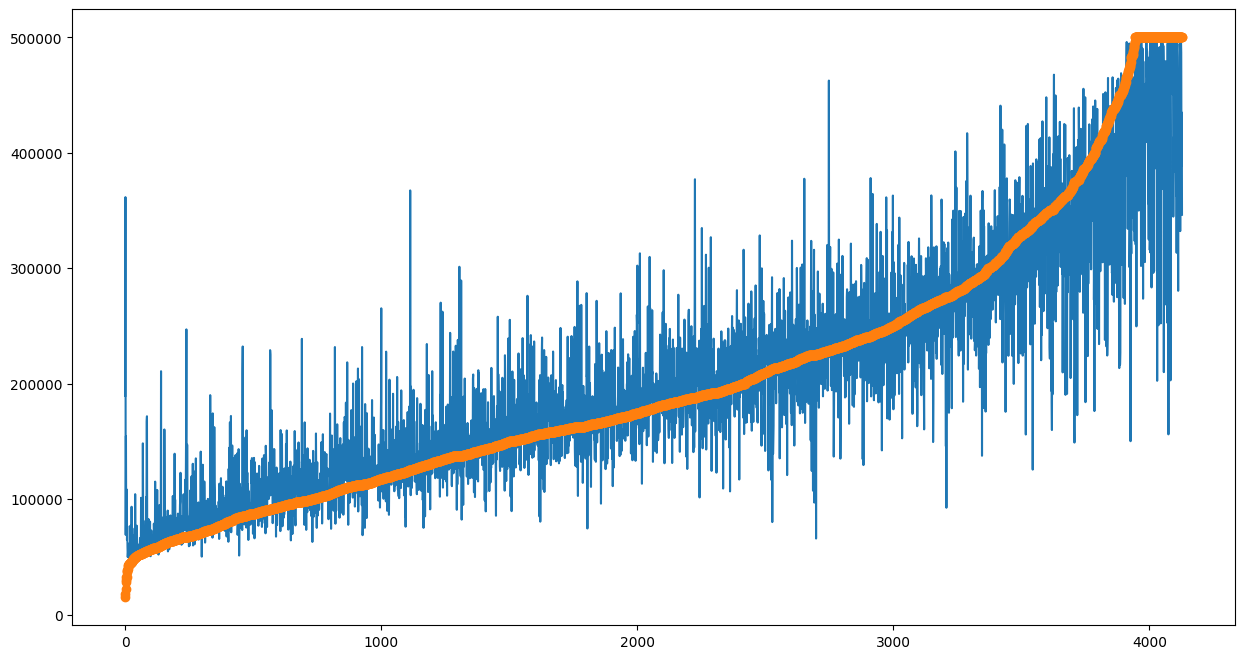

In [51]:
_, ax = plt.subplots(figsize=(15,8))
plt.plot(e['prediction'],'-',e['reality'],'-o')
plt.show();

In [52]:
rfr.score(X_test_prepared, y_test)

0.8210024137396555

In [53]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error
print("RMSE",pow(mean_squared_error(y_test,y_pred),0.5))
print('mean absolute error', mean_absolute_error(y_test,y_pred))
print('Median absolute error', median_absolute_error(y_test,y_pred))

RMSE 48431.39933132279
mean absolute error 31294.33695161095
Median absolute error 19240.388750000013


In [54]:
def improved_accuracy(df,col=['pred','test'],percent=0.2):
    df['difference'] = abs(df[col[0]] - df[col[1]])/df[col[1]]
    txt = f'difference <= {percent}'
    return df.query(txt).shape[0]/df.shape[0]

In [55]:
improved_accuracy(df=e, col=['prediction','reality'], percent=0.01)

0.05935077519379845

In [56]:
improved_accuracy(df=e, col=['prediction','reality'], percent=0.05)

0.2606589147286822

In [57]:
improved_accuracy(df=e, col=['prediction','reality'], percent=0.1)

0.45373062015503873

In [58]:
improved_accuracy(df=e, col=['prediction','reality'], percent=0.2)

0.719234496124031